In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from fullfrlm import flow_refueling_location_model

In [2]:
## Load necessary data
G = pickle.load(open('data/cleaned_network.p', 'rb'))
df_h = pickle.load(open("data/harbour_data_100.p", "rb"))
df_ivs = pickle.load(open("data/ivs_exploded_100.p", "rb"))
paths = pickle.load(open("data/paths_ship_specific_routes.p", "rb"))
path_lengths = pickle.load(open("data/path_lengths_ship_specific_routes.p", "rb"))

In [3]:
import time
%time flow_refueling_location_model(load=1, r=50000, stations_to_place=10, station_cap=5, max_per_loc=5)

CPU times: total: 6.12 s
Wall time: 6.49 s


(1257.567514677104, 0.03480732705140697)

## Works, now connect to workbench

In [4]:
# from ema_workbench import IntegerParameter, RealParameter, Model, ScalarOutcome, ArrayOutcome
# model = Model("frlm", function=flow_refueling_location_model)
#

## Run model for 50 scenarios and 25 policies

In [5]:

# specify uncertainties
# model.uncertainties = [
#     RealParameter("load", 0, 1),
#     IntegerParameter("r", 50000, 200000),
# ]
#
# # set levers
# model.levers = [
#     IntegerParameter("stations_to_place", 1, 350),
#     IntegerParameter("station_cap", 1, 5),
#     IntegerParameter("max_per_loc", 1, 5),
# ]
#
# # specify outcomes
# model.outcomes = [
#     ScalarOutcome("total_flow"),
#     ScalarOutcome("supported_fraction"),
# ]

In [6]:
# from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator, ema_logging, perform_experiments
#
# ema_logging.log_to_stderr(ema_logging.INFO)
#
# with MultiprocessingEvaluator(model, n_processes=8) as evaluator:
#     experiments, outcomes = evaluator.perform_experiments(scenarios=50, policies=25)

In [7]:
# pickle.dump( experiments, open( "results/experiments_50s_25.p", "wb" ) )
# pickle.dump( outcomes, open("results/outcomes_50s_25.p", "wb") )
experiments = pickle.load( open("results/experiments_50s_25.p", "rb"))
outcomes = pickle.load( open("results/outcomes_50s_25.p", "rb"))

## Run model for 300 and 10 policies without changing station cap and max per loc

In [8]:
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator, ema_logging, perform_experiments
from ema_workbench import IntegerParameter, RealParameter, Model, ScalarOutcome, ArrayOutcome, Constant
ema_logging.log_to_stderr(ema_logging.INFO)

model = Model("frlm", function=flow_refueling_location_model)


In [9]:

# specify uncertainties
model.uncertainties = [
    RealParameter("load", 0, 1),
    IntegerParameter("r", 50000, 200000),
]

# set levers
model.levers = [
    IntegerParameter("stations_to_place", 1, 350),
]

# specify outcomes
model.outcomes = [
    ScalarOutcome("total_flow"),
    ScalarOutcome("supported_fraction"),
]

model.constants = [
    Constant("station_cap", 5),
    Constant("max_per_loc", 5),
]

In [10]:
# with MultiprocessingEvaluator(model, n_processes=7) as evaluator:
#     experiments_new, outcomes_new = evaluator.perform_experiments(scenarios=300, policies=10)

[MainProcess/INFO] pool started with 7 workers
[MainProcess/INFO] performing 300 scenarios * 10 policies * 1 model(s) = 3000 experiments
100%|████████████████████████████████████| 3000/3000 [3:58:14<00:00,  4.76s/it]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [11]:
# pickle.dump( experiments_new, open( "results/experiments_300s_10.p", "wb" ) )
# pickle.dump( outcomes_new, open("results/outcomes_300s_10.p", "wb") )

## Visualize results for each policy in a pairplot

In [12]:
policies = experiments["policy"]
for i, policy in enumerate(np.unique(policies)):
    experiments.loc[policies == policy, "policy"] = str(i)

data = pd.DataFrame(outcomes)
data["policy"] = policies

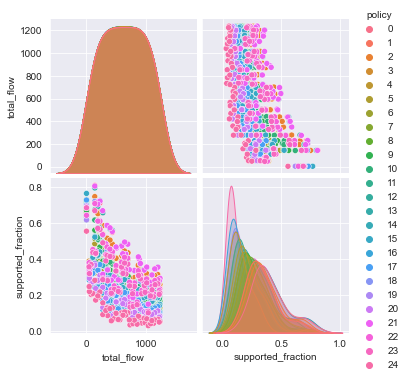

In [13]:
sns.pairplot(data, hue="policy", vars=list(outcomes.keys()))
plt.show()

## "Normal" pairplot?

In [14]:
all_data = experiments.copy()
all_data['total_flow'] = outcomes['total_flow']
all_data['supported_fraction'] = outcomes['supported_fraction']

In [15]:
all_data = all_data.loc[:, ['load','r','max_per_loc','station_cap', 'stations_to_place','total_flow','supported_fraction']]

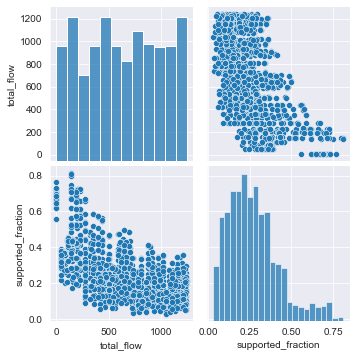

In [16]:
sns.pairplot(all_data, vars=list(outcomes.keys()))

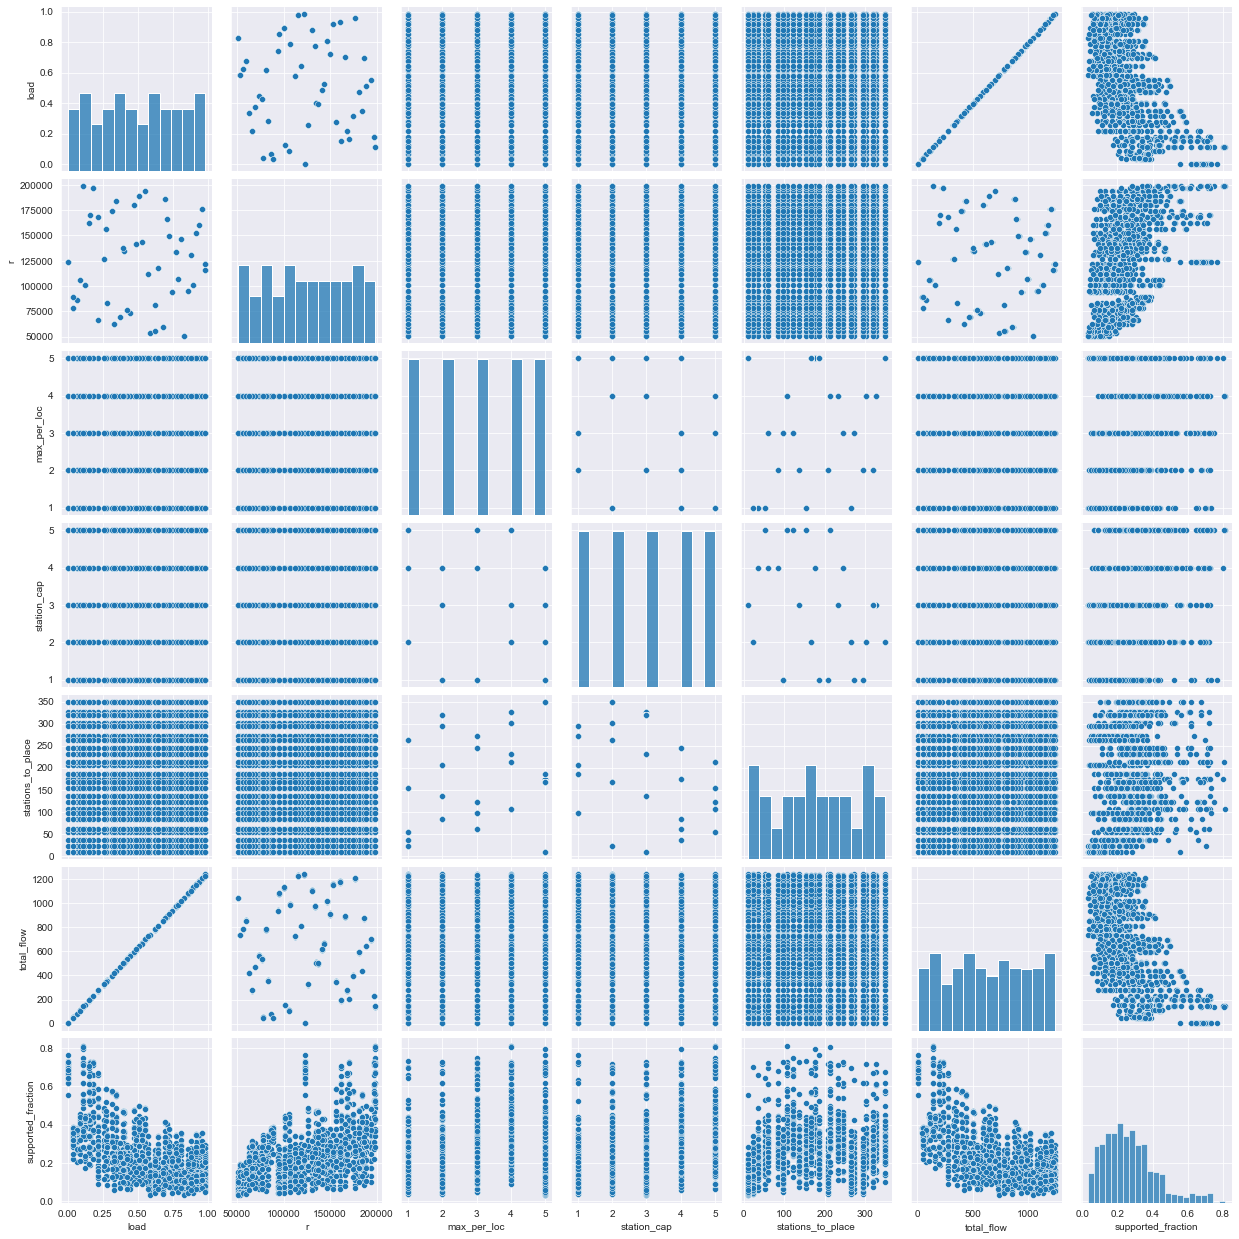

In [17]:
sns.pairplot(all_data)

## Visualize how results are correlated

[MainProcess/INFO] no time dimension found in results


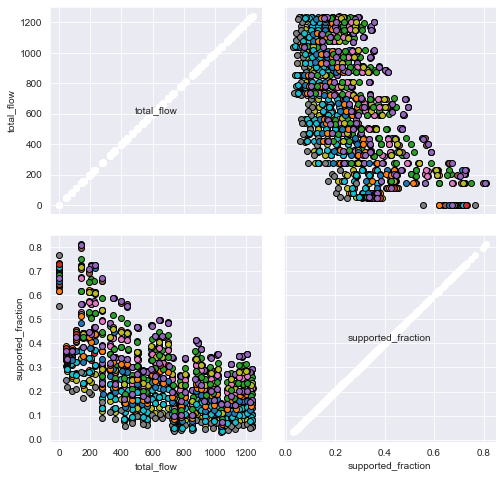

In [18]:
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(
    experiments, outcomes, group_by="policy", legend=False
)
fig.set_size_inches(8, 8)
plt.show()

In [19]:
from ema_workbench.analysis import prim
%matplotlib inline
x = experiments
y = (1-outcomes["supported_fraction"]) < 0.8
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 1250 points remaining, containing 796 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.2464, coverage: 0.3869346733668342, density: 1.0 restricted_dimensions: 4


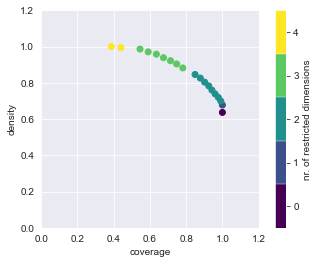

In [20]:
box1.show_tradeoff()
plt.show()

coverage     0.781407
density      0.882270
id          10.000000
mass         0.564000
mean         0.882270
res_dim      3.000000
Name: 10, dtype: float64

                                                        box 10  \
                                                           min   
policy       {7, 6, 9, 23, 0, 12, 14, 13, 21, 2, 3, 8, 15, ...   
r                                                      57859.0   
max_per_loc                                                1.5   

                                                                \
                                                           max   
policy       {7, 6, 9, 23, 0, 12, 14, 13, 21, 2, 3, 8, 15, ...   
r                                                     198493.0   
max_per_loc                                                5.0   

                                             
                                  qp values  
policy       [1.5525560228037758e-21, -1.0]  
r             [4.015353502301289e-05, -1.0

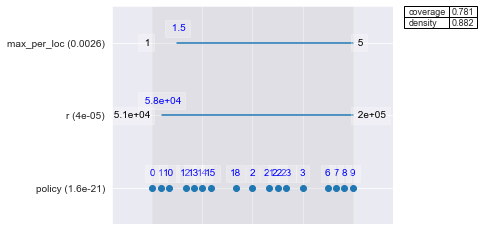

In [21]:
box1.inspect(10)
box1.inspect(10, style="graph")
plt.show()

C:\Users\Fabia\Anaconda3\envs\ox\lib\site-packages\ema_workbench\analysis\scenario_discovery_util.py:419: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


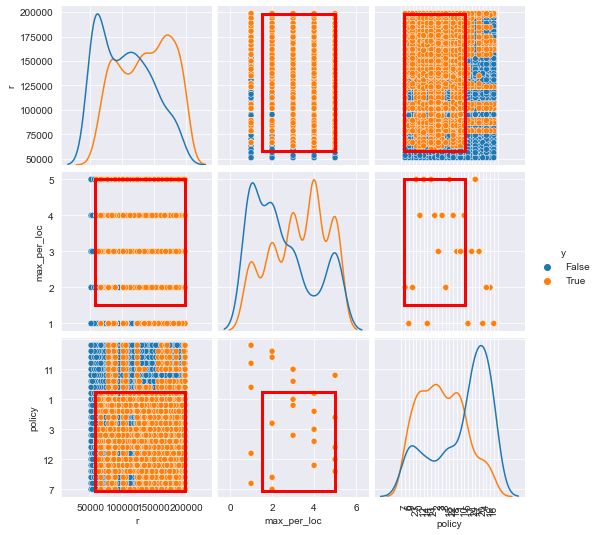

In [22]:
box1.show_pairs_scatter(10)
plt.show()

[MainProcess/INFO] model dropped from analysis because only a single category
C:\Users\Fabia\Anaconda3\envs\ox\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
[MainProcess/INFO] model dropped from analysis because only a single category
C:\Users\Fabia\Anaconda3\envs\ox\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Fabia\Anaconda3\envs\ox\lib\site-packages\ema_workbench\analysis\feature_scoring.py:389: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete = complete.append(fs.T, sort=True)


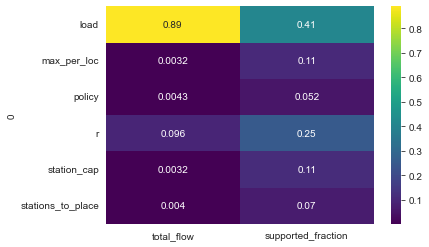

In [23]:
from ema_workbench.analysis import feature_scoring

x = experiments
y = outcomes

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True)
plt.show()

[MainProcess/INFO] model dropped from analysis because only a single category


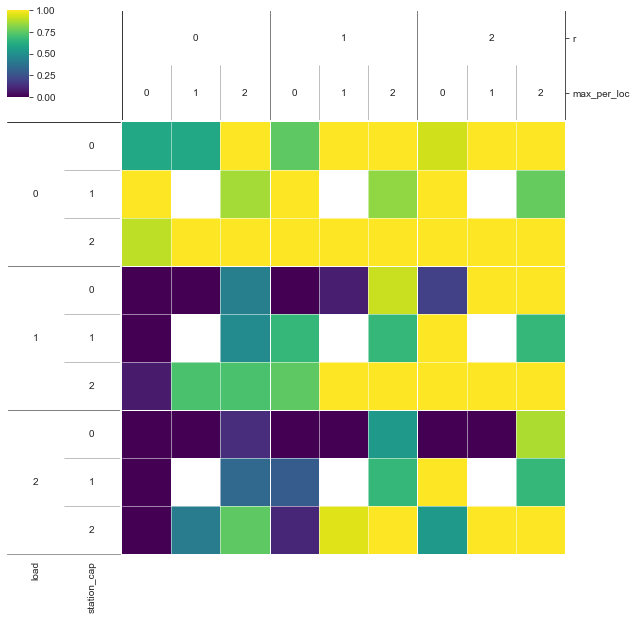

In [24]:
from ema_workbench.analysis import dimensional_stacking

x = experiments
y = (1-outcomes["supported_fraction"]) < 0.8
dimensional_stacking.create_pivot_plot(x, y, 2, nbins=3)
plt.show()

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U1'), dtype('float64')) -> None

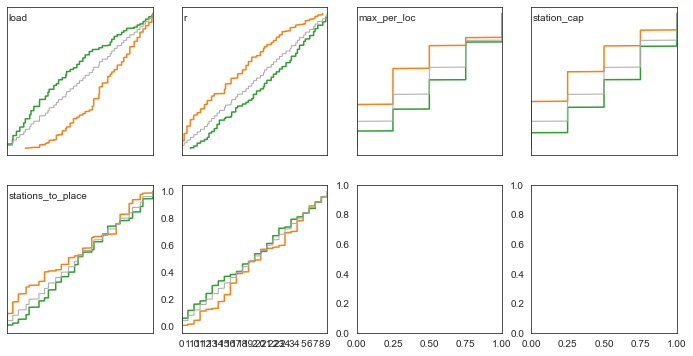

In [26]:
from ema_workbench.analysis import regional_sa
from numpy.lib import recfunctions as rf

sns.set_style("white")

# model is the same across experiments
x = experiments.copy()
x = x.drop("model", axis=1)
y = (1-outcomes["supported_fraction"]) < 0.8
fig = regional_sa.plot_cdfs(x, y)
sns.despine()
plt.show()

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U1'), dtype('float64')) -> None

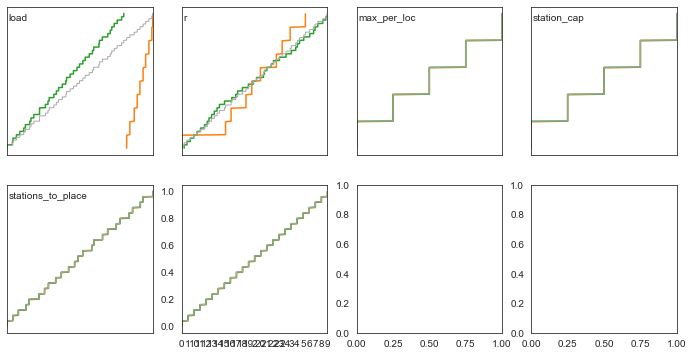

In [27]:
from ema_workbench.analysis import regional_sa
from numpy.lib import recfunctions as rf

sns.set_style("white")

# model is the same across experiments
x = experiments.copy()
x = x.drop("model", axis=1)
y = (outcomes["total_flow"]) < 1000
fig = regional_sa.plot_cdfs(x, y)
sns.despine()
plt.show()

## Sobol sampling

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from fullfrlm import flow_refueling_location_model

## Load necessary data
G = pickle.load(open('data/cleaned_network.p', 'rb'))
df_h = pickle.load(open("data/harbour_data_100.p", "rb"))
df_ivs = pickle.load(open("data/ivs_exploded_100.p", "rb"))
paths = pickle.load(open("data/paths_ship_specific_routes.p", "rb"))
path_lengths = pickle.load(open("data/path_lengths_ship_specific_routes.p", "rb"))

In [ ]:
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator
from SALib.analyze import sobol
from ema_workbench import Samplers, Model
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

model = Model("frlm", function=flow_refueling_location_model)

In [ ]:
from ema_workbench import IntegerParameter, RealParameter, Model, ScalarOutcome, ArrayOutcome

model = Model("frlm", function=flow_refueling_location_model)
#

# specify uncertainties
model.uncertainties = [
    RealParameter("load", 0, 1),
    IntegerParameter("r", 50000, 200000),
    IntegerParameter("stations_to_place", 1, 350),
    IntegerParameter("station_cap", 1, 5),
    IntegerParameter("max_per_loc", 1, 5)
]

# set levers
# model.levers = [
#     IntegerParameter("stations_to_place", 1, 350),
#     IntegerParameter("station_cap", 1, 5),
#     IntegerParameter("max_per_loc", 1, 5),
# ]

# specify outcomes
model.outcomes = [
    ScalarOutcome("total_flow"),
    ScalarOutcome("supported_fraction"),
]

In [ ]:
with MultiprocessingEvaluator(model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=1000, uncertainty_sampling=Samplers.SOBOL)

In [ ]:
pickle.dump( sa_results, open( "results/sa_1000.p", "wb" ) )

In [ ]:

experiments, outcomes = sa_results

problem = get_SALib_problem(model.uncertainties)
Si = sobol.analyze(
    problem, outcomes["supported_fraction"], calc_second_order=True, print_to_console=False
)

## Investigate sensitivity to harbour locations

In [ ]:
from math import ceil
from fullfrlm import random_vessel_generator
from fullfrlm import flow_computation

#create empty list to select nodes to choose from
opt_nodes = []

#choose range and load
r=50000
load=1

#generate sample and compute flows for paths
df_random = random_vessel_generator(df_ivs, load)
flows = flow_computation(df_random)

# 1 randomly pick nodes which are in many routes?
#reminder: the longest route is 800000m
for i in paths.keys():
    # i station enough?
    if path_lengths[i]*2 > r:
        print("Any O or D optimal for path", i)
    else:
        # how many required if any place may be selected?
        req_on_route = ceil(path_lengths[i]/r)+1
